## The Truth Layer: Validating AI-Generated Research

This notebook demonstrates a system for validating AI-generated research reports by
checking whether the claims made in the report are supported by the sources it cites.


In [1]:
# Install required packages
# !pip install -q python-dotenv instructor openai firecrawl-py anthropic pandas rich tqdm pydantic matplotlib


In [2]:
# %%
# Import necessary libraries
import os
import json
from typing import Optional, Literal, Any
from datetime import datetime
import time
import re
import uuid
import warnings
from urllib.parse import quote

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from dotenv import load_dotenv
import instructor
from openai import OpenAI
from firecrawl import FirecrawlApp
from rich.console import Console
from rich.panel import Panel
from pydantic import BaseModel, Field

import tqdm

# Suppress warning messages
warnings.filterwarnings("ignore")

In [3]:
# Configure visualization styles
plt.style.use("fivethirtyeight")
sns.set_palette("viridis")

In [4]:
# Set up rich console for pretty printing
console = Console()

# %%
# Load environment variables
load_dotenv()

True

In [5]:
# Set up API clients
openai_client = instructor.from_openai(OpenAI())
default_client = openai_client

In [6]:
default_model = "o3-mini"

In [7]:
# Initialize Firecrawl SDK with API key
firecrawl_api_key = os.environ["FIRECRAWL_API_KEY"]
firecrawl_app = FirecrawlApp(api_key=firecrawl_api_key)


### 1. Data Models

First, we'll define our data models using Pydantic, which will be used with the Instructor library for structured LLM outputs.

Define Pydantic models for structured data

In [8]:
class Source(BaseModel):
    """A source referenced in a research report"""

    id: str = Field(description="Unique identifier for the source")
    url: str = Field(description="URL of the source")
    title: Optional[str] = Field(None, description="Title of the source")
    content: Optional[str] = Field(None, description="The source content")


class Claim(BaseModel):
    """A claim made in a research report that needs verification"""

    id: str = Field(description="Unique identifier for the claim")
    statement: str = Field(description="The claim as stated in the report")
    verification_question: str = Field(
        description="The claim rewritten as a verification question"
    )
    source_urls: list[str] = Field(description="URLs of sources this claim references")
    source_ids: list[str] = Field(
        default_factory=list, description="Source IDs (populated in post-processing)"
    )


class ValidationResult(BaseModel):
    """The validation result for a claim"""

    claim_id: str = Field(description="ID of the claim")
    statement: str = Field(description="The original claim statement")
    verification_question: str = Field(description="The verification question")
    status: Literal[
        "SUPPORTED", "PARTIALLY_SUPPORTED", "CONTRADICTED", "UNVERIFIABLE"
    ] = Field(description="Validation status")
    confidence: float = Field(description="Confidence score (0.0-1.0)")
    reasoning: str = Field(description="Explanation of the validation")
    has_contradictions: bool = Field(
        False, description="Whether sources contradict each other"
    )


class ExtractedReport(BaseModel):
    """The extracted claims and sources from a report"""

    claims: list[Claim] = Field(description="List of extracted claims")
    sources: list[Source] = Field(description="List of extracted sources")


class TrustReport(BaseModel):
    """Final trust report for a validated document"""

    id: str = Field(description="Report ID")
    timestamp: str = Field(description="When the validation was performed")
    trust_score: float = Field(description="Overall trust score (0-100)")
    claim_count: int = Field(description="Total number of claims")
    results: dict[str, int] = Field(description="Counts by validation status")
    has_contradictions: bool = Field(
        False, description="Whether any sources contradict each other"
    )

### 2. Extract Claims and Sources from Report
The first step is to extract claims and their associated sources from an AI-generated research report. 
We'll use Instructor to get structured output from an LLM.


In [9]:
def extract_claims_and_sources(report_text: str) -> ExtractedReport:
    """Extract claims and their source URLs from a report"""
    console.print("[blue]Extracting claims and sources...[/blue]")

    # Generate unique IDs for this report
    report_id = str(uuid.uuid4())[:8]

    # Extract with LLM
    result = openai_client.chat.completions.create(
        model=default_model,
        response_model=ExtractedReport,
        messages=[
            {
                "role": "system",
                "content": """Extract verifiable claims and their associated sources from this research report.
             
             For each claim:
             1. Extract the exact statement from the text
             2. Create a verification question that precisely addresses what needs to be verified
             3. Identify which URLs from the sources are referenced by this claim
             
             Extract all sources (URLs) referenced in the document.
             
             Only include factual claims that can be objectively verified.
             Focus on claims with explicit source references.""",
            },
            {"role": "user", "content": report_text},
        ],
    )

    # Assign IDs to claims and sources
    for i, source in enumerate(result.sources):
        source.id = f"source-{report_id}-{i}"

    for i, claim in enumerate(result.claims):
        claim.id = f"claim-{report_id}-{i}"

    # Link claims to source IDs
    url_to_source_id = {source.url: source.id for source in result.sources}

    for claim in result.claims:
        claim.source_ids = [
            url_to_source_id.get(url)
            for url in claim.source_urls
            if url in url_to_source_id
        ]
        # Filter out None values
        claim.source_ids = [
            source_id for source_id in claim.source_ids if source_id is not None
        ]

    console.print(
        f"[green]Extracted {len(result.claims)} claims and {len(result.sources)} sources[/green]"
    )
    return result

### 3. Fetch Source Content
Next, we need to fetch the content of each cited source. We'll use the Firecrawl SDK to convert web pages into markdown content optimized for LLM processing.


In [10]:
def fetch_sources(sources: list[Source]) -> list[Source]:
    """Fetch content for all sources using Firecrawl"""
    console.print("[blue]Fetching source content...[/blue]")

    if not firecrawl_app:
        console.print(
            "[red]Firecrawl API not configured. Cannot fetch source content.[/red]"
        )
        return sources

    for i, source in enumerate(sources):
        console.print(f"Fetching source {i + 1}/{len(sources)}: {source.url}")
        try:
            # Use Firecrawl to get markdown
            result = firecrawl_app.scrape_url(
                source.url, params={"formats": ["markdown"]}
            )

            if result and "markdown" in result:
                source.content = result["markdown"]
            else:
                source.content = f"Error fetching content from {source.url}"
        except Exception as e:
            source.content = f"Error: {str(e)}"

    console.print("[green]Finished fetching source content[/green]")
    return sources

### 4. Validate Claims Against Sources
Now we'll validate each claim against its associated sources using an LLM with structured output.


In [11]:
def validate_claim(claim: Claim, sources: list[Source]) -> ValidationResult:
    """Validate a claim against its sources in a single LLM call"""
    # Get sources for this claim
    claim_sources = [s for s in sources if s.id in claim.source_ids]

    # If no sources, return unverifiable
    if not claim_sources:
        return ValidationResult(
            claim_id=claim.id,
            statement=claim.statement,
            verification_question=claim.verification_question,
            status="UNVERIFIABLE",
            confidence=0.0,
            reasoning="No sources available for this claim",
            has_contradictions=False,
        )

    # Prepare sources text
    sources_text = "\n\n".join(
        [f"SOURCE [{s.id}] {s.url}:\n{s.content}" for s in claim_sources]
    )

    # Validate with LLM
    result = openai_client.chat.completions.create(
        model=default_model,
        response_model=ValidationResult,
        messages=[
            {
                "role": "system",
                "content": """Assess whether this claim is supported by its cited sources.
             
             Only use information from the provided sources. Do not use general knowledge.
             
             Possible statuses:
             - SUPPORTED: The claim is directly supported by the sources
             - PARTIALLY_SUPPORTED: The claim is supported with some caveats
             - CONTRADICTED: The sources contradict the claim
             - UNVERIFIABLE: Not enough information in the sources
             
             If sources contradict each other, note this in your reasoning and set has_contradictions to true.""",
            },
            {
                "role": "user",
                "content": f"""CLAIM: {claim.statement}
             
             VERIFICATION QUESTION: {claim.verification_question}
             
             SOURCES:
             {sources_text}
             
             Analyze whether this claim is supported by these sources.""",
            },
        ],
    )

    # Fill in claim details
    result.claim_id = claim.id
    result.statement = claim.statement
    result.verification_question = claim.verification_question

    return result


# %%
def validate_all_claims(
    claims: list[Claim], sources: list[Source]
) -> list[ValidationResult]:
    """Validate all claims against their sources"""
    console.print("[blue]Validating claims...[/blue]")

    results = []
    for i, claim in enumerate(claims):
        console.print(
            f"Validating claim {i + 1}/{len(claims)}: {claim.statement[:50]}..."
        )
        result = validate_claim(claim, sources)
        results.append(result)

    console.print(f"[green]Validated {len(results)} claims[/green]")
    return results

### 5. Calculate Trust Score and Generate Report
Finally, we'll calculate an overall trust score for the report and generate a summary of the validation results.


In [12]:
def calculate_trust_score(validation_results: list[ValidationResult]) -> float:
    """Calculate the overall trust score based on validation results"""
    if not validation_results:
        return 0.0

    # Define weights for each status
    weights = {
        "SUPPORTED": 1.0,
        "PARTIALLY_SUPPORTED": 0.5,
        "CONTRADICTED": 0.0,
        "UNVERIFIABLE": 0.0,
    }

    # Calculate weighted sum
    weighted_sum = sum(
        weights[result.status] * result.confidence for result in validation_results
    )

    # Calculate average and scale to 0-100
    trust_score = (weighted_sum / len(validation_results)) * 100

    # Apply a penalty for contradictions
    contradictions = sum(1 for r in validation_results if r.has_contradictions)
    if contradictions > 0:
        contradiction_penalty = min(20, contradictions * 5)  # Cap penalty at 20%
        trust_score = max(0, trust_score - contradiction_penalty)

    return round(trust_score, 1)


# %%
def generate_trust_report(validation_results: list[ValidationResult]) -> TrustReport:
    """Generate a trust report from validation results"""
    # Count results by status
    status_counts = {
        "SUPPORTED": 0,
        "PARTIALLY_SUPPORTED": 0,
        "CONTRADICTED": 0,
        "UNVERIFIABLE": 0,
    }

    for result in validation_results:
        status_counts[result.status] += 1

    # Check if any sources contradict each other
    has_contradictions = any(r.has_contradictions for r in validation_results)

    # Calculate trust score
    trust_score = calculate_trust_score(validation_results)

    return TrustReport(
        id=str(uuid.uuid4())[:8],
        timestamp=datetime.now().isoformat(),
        trust_score=trust_score,
        claim_count=len(validation_results),
        results=status_counts,
        has_contradictions=has_contradictions,
    )

# ## 6. Visualization Functions
These functions create elegant visualizations of our validation results.


In [23]:
def plot_trust_gauge(trust_score: float):
    """Create a gauge visualization of the trust score"""
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": "polar"})

    # Convert trust score to radians (0-100 to 0-π)
    angle = np.pi * (trust_score / 100)

    # Create the gauge
    theta = np.linspace(0, np.pi, 100)

    # Create color gradients
    low_trust = LinearSegmentedColormap.from_list("low_trust", ["#FF0000", "#FFAA00"])
    mid_trust = LinearSegmentedColormap.from_list("mid_trust", ["#FFAA00", "#AAFF00"])
    high_trust = LinearSegmentedColormap.from_list("high_trust", ["#AAFF00", "#00FF00"])

    # Plot the gauge background
    ax.fill_between(theta, 0.7, 0.9, color="#EEEEEE", alpha=0.8)

    # Plot the colored sections
    ax.fill_between(
        theta[0:33], 0.7, 0.9, color=low_trust(np.linspace(0, 1, 33)), alpha=0.8
    )
    ax.fill_between(
        theta[33:66], 0.7, 0.9, color=mid_trust(np.linspace(0, 1, 33)), alpha=0.8
    )
    ax.fill_between(
        theta[66:100], 0.7, 0.9, color=high_trust(np.linspace(0, 1, 34)), alpha=0.8
    )

    # Plot the needle
    ax.plot([0, angle], [0, 0.8], color="black", linewidth=3)
    ax.scatter(0, 0, color="black", s=100)

    # Add score text
    ax.text(
        np.pi / 2,
        0.4,
        f"{trust_score:.1f}%",
        fontsize=24,
        fontweight="bold",
        ha="center",
        va="center",
    )
    ax.text(np.pi / 2, 0.2, "Trust Score", fontsize=16, ha="center", va="center")

    # Add labels
    ax.text(0, 1.0, "0%", fontsize=12, ha="left", va="center")
    ax.text(np.pi / 2, 1.0, "50%", fontsize=12, ha="center", va="center")
    ax.text(np.pi, 1.0, "100%", fontsize=12, ha="right", va="center")

    # Customize ticks and grid
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["polar"].set_visible(False)

    plt.tight_layout()
    plt.show()


# %%
def plot_claim_distribution(trust_report: TrustReport):
    """Create a pie chart of claim validation statuses"""
    labels = []
    sizes = []
    colors = {
        "SUPPORTED": "#00CC00",
        "PARTIALLY_SUPPORTED": "#CCCC00",
        "CONTRADICTED": "#CC0000",
        "UNVERIFIABLE": "#CCCCCC",
    }
    color_list = []

    for status, count in trust_report.results.items():
        if count > 0:
            labels.append(status)
            sizes.append(count)
            color_list.append(colors[status])

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        colors=color_list,
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor": "w", "linewidth": 2},
    )

    # Customize text
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_weight("bold")
        autotext.set_color("white")

    # Add legend
    ax.legend(
        wedges,
        [f"{label} ({size})" for label, size in zip(labels, sizes)],
        title="Validation Status",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
    )

    plt.title("Claim Validation Results", fontsize=16, fontweight="bold", pad=20)
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()


# %%
def plot_confidence_per_claim(validation_results: list[ValidationResult]):
    """Create a bar chart of confidence scores for each claim"""
    # Prepare data
    claims = [f"Claim {i + 1}" for i in range(len(validation_results))]
    confidences = [r.confidence for r in validation_results]
    statuses = [r.status for r in validation_results]

    # Define colors for each status
    colors = {
        "SUPPORTED": "#00CC00",
        "PARTIALLY_SUPPORTED": "#CCCC00",
        "CONTRADICTED": "#CC0000",
        "UNVERIFIABLE": "#CCCCCC",
    }

    # Create colormap
    bar_colors = [colors[status] for status in statuses]

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars
    bars = ax.bar(claims, confidences, color=bar_colors, alpha=0.7)

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.02,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Customize plot
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Confidence Score", fontsize=12)
    ax.set_xlabel("Claims", fontsize=12)
    ax.set_title("Confidence Score per Claim", fontsize=16, fontweight="bold", pad=20)

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=colors[status], label=status)
        for status in colors.keys()
        if status in statuses
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    # Add grid
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


# %%
def display_validation_results(
    trust_report: TrustReport,
    validation_results: list[ValidationResult],
    extracted: ExtractedReport,
):
    """Display comprehensive results with visualizations"""
    console.print(
        Panel.fit(
            f"[bold]Trust Score:[/bold] {trust_report.trust_score}/100\n"
            f"[bold]Claims Analyzed:[/bold] {trust_report.claim_count}\n"
            f"[bold]Supported:[/bold] {trust_report.results['SUPPORTED']} "
            f"({trust_report.results['SUPPORTED'] / trust_report.claim_count * 100:.1f}%)\n"
            f"[bold]Partially Supported:[/bold] {trust_report.results['PARTIALLY_SUPPORTED']} "
            f"({trust_report.results['PARTIALLY_SUPPORTED'] / trust_report.claim_count * 100:.1f}%)\n"
            f"[bold]Contradicted:[/bold] {trust_report.results['CONTRADICTED']} "
            f"({trust_report.results['CONTRADICTED'] / trust_report.claim_count * 100:.1f}%)\n"
            f"[bold]Unverifiable:[/bold] {trust_report.results['UNVERIFIABLE']} "
            f"({trust_report.results['UNVERIFIABLE'] / trust_report.claim_count * 100:.1f}%)\n"
            f"[bold]Source Contradictions:[/bold] {'Yes' if trust_report.has_contradictions else 'No'}",
            title=f"Truth Layer Report: {trust_report.id}",
            border_style="blue",
        )
    )

    # Visualize results
    plot_trust_gauge(trust_report.trust_score)
    plot_claim_distribution(trust_report)
    plot_confidence_per_claim(validation_results)

    # Create a lookup dictionary for claim_id -> source_ids length
    claim_id_to_source_count = {
        claim.id: len(claim.source_ids) for claim in extracted.claims
    }

    # Display detailed results in a DataFrame
    results_df = pd.DataFrame(
        [
            {
                "Claim": r.statement[:80] + "..."
                if len(r.statement) > 80
                else r.statement,
                "Status": r.status,
                "Confidence": r.confidence,
                "Source Count": claim_id_to_source_count.get(
                    r.claim_id, 0
                ),  # Corrected source count
                "Contradictions": "Yes" if r.has_contradictions else "No",
            }
            for r in validation_results
        ]
    )

    return results_df

### 7. End-to-End Validation Pipeline
Now, let's combine all the pieces into an end-to-end validation pipeline.


In [24]:
def validate_report(
    report_text: str,
) -> tuple[TrustReport, list[ValidationResult], ExtractedReport]:
    """Run the complete validation pipeline on a research report"""
    # Step 1: Extract claims and sources
    extracted = extract_claims_and_sources(report_text)

    # Step 2: Fetch source content
    sources_with_content = fetch_sources(extracted.sources)

    # Step 3: Validate each claim against its sources
    validation_results = validate_all_claims(extracted.claims, sources_with_content)

    # Step 4: Generate trust report
    trust_report = generate_trust_report(validation_results)

    return trust_report, validation_results, extracted

In [15]:
sample_report = """

**A Very Short History of Abraham Lincoln**

Abraham Lincoln was born on February 12, 1809, in a log cabin in Kentucky. He was largely self-educated and worked as a lawyer before entering politics in Illinois. His election as the 16th President of the United States in 1860 led to the secession of Southern states and the start of the Civil War[^1][^3].

As president, Lincoln focused on preserving the Union. In 1863, he issued the Emancipation Proclamation, declaring freedom for enslaved people in Confederate-held territories and reframing the war around the abolition of slavery[^3][^5]. That same year, he delivered the Gettysburg Address, a defining speech in American history.

Lincoln was re-elected in 1864 and oversaw the Union’s victory in April 1865. Just days later, on April 14, he was assassinated by John Wilkes Booth. His leadership during the Civil War and his moral vision for the nation cemented his legacy as one of America’s greatest presidents[^3][^4][^6].

---

**Sources**

[^1]: https://en.wikipedia.org/wiki/Abraham_Lincoln  
[^3]: https://millercenter.org/president/lincoln/life-in-brief  
[^4]: https://en.wikipedia.org/wiki/Abraham_Lincoln  
[^5]: https://www.battlefields.org/learn/biographies/abraham-lincoln  
[^6]: https://kids.nationalgeographic.com/history/article/abraham-lincoln  

"""

In [16]:
# Run the validation pipeline
trust_report, validation_results, extracted = validate_report(sample_report)

Extracting claims and sources...

Extracted 5 claims and 5 sources

Fetching source content...

Fetching source 1/5: https://en.wikipedia.org/wiki/Abraham_Lincoln

Fetching source 2/5: https://millercenter.org/president/lincoln/life-in-brief

Fetching source 3/5: https://en.wikipedia.org/wiki/Abraham_Lincoln

Fetching source 4/5: https://www.battlefields.org/learn/biographies/abraham-lincoln

Fetching source 5/5: https://kids.nationalgeographic.com/history/article/abraham-lincoln

Finished fetching source content

Validating claims...

Validating claim 1/5: Abraham Lincoln was born on February 12, 1809, in ...

Validating claim 2/5: He was largely self-educated and worked as a lawye...

Validating claim 3/5: His election as the 16th President of the United S...

Validating claim 4/5: In 1863, he issued the Emancipation Proclamation, ...

Validating claim 5/5: His leadership during the Civil War and his moral ...

Validated 5 claims

In [17]:
extracted.claims

[Claim(id='claim-098920da-0', statement='Abraham Lincoln was born on February 12, 1809, in a log cabin in Kentucky.', verification_question='Can it be verified that Abraham Lincoln was born on February 12, 1809, in a log cabin in Kentucky?', source_urls=['https://en.wikipedia.org/wiki/Abraham_Lincoln', 'https://millercenter.org/president/lincoln/life-in-brief'], source_ids=['source-098920da-2', 'source-098920da-1']),
 Claim(id='claim-098920da-1', statement='He was largely self-educated and worked as a lawyer before entering politics in Illinois.', verification_question='Is it verifiable that Abraham Lincoln was largely self-educated and worked as a lawyer before entering politics in Illinois?', source_urls=['https://en.wikipedia.org/wiki/Abraham_Lincoln', 'https://millercenter.org/president/lincoln/life-in-brief'], source_ids=['source-098920da-2', 'source-098920da-1']),
 Claim(id='claim-098920da-2', statement='His election as the 16th President of the United States in 1860 led to the s

╭─ Truth Layer Report: ba303566 ─╮
│ Trust Score: 100.0/100         │
│ Claims Analyzed: 5             │
│ Supported: 5 (100.0%)          │
│ Partially Supported: 0 (0.0%)  │
│ Contradicted: 0 (0.0%)         │
│ Unverifiable: 0 (0.0%)         │
│ Source Contradictions: No      │
╰────────────────────────────────╯

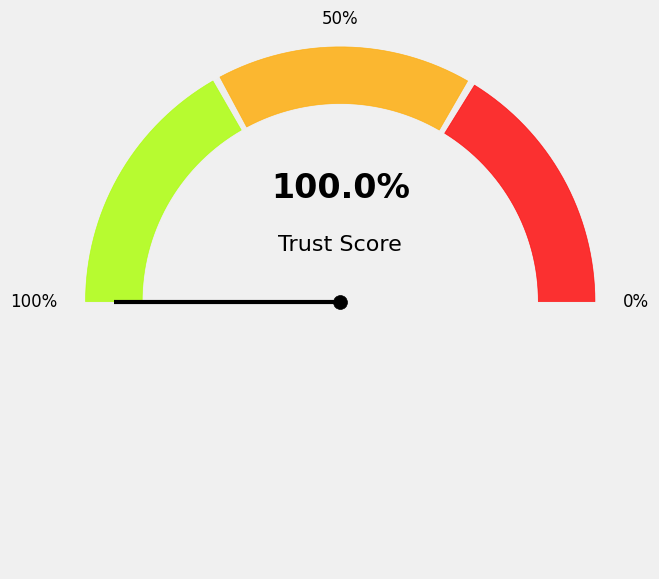

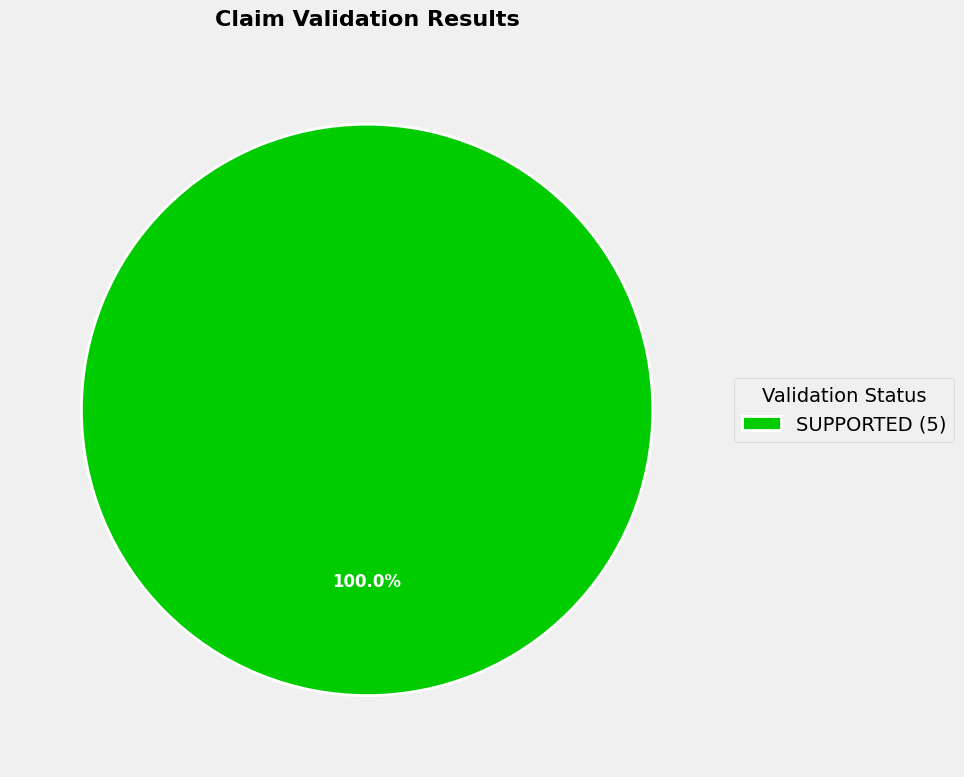

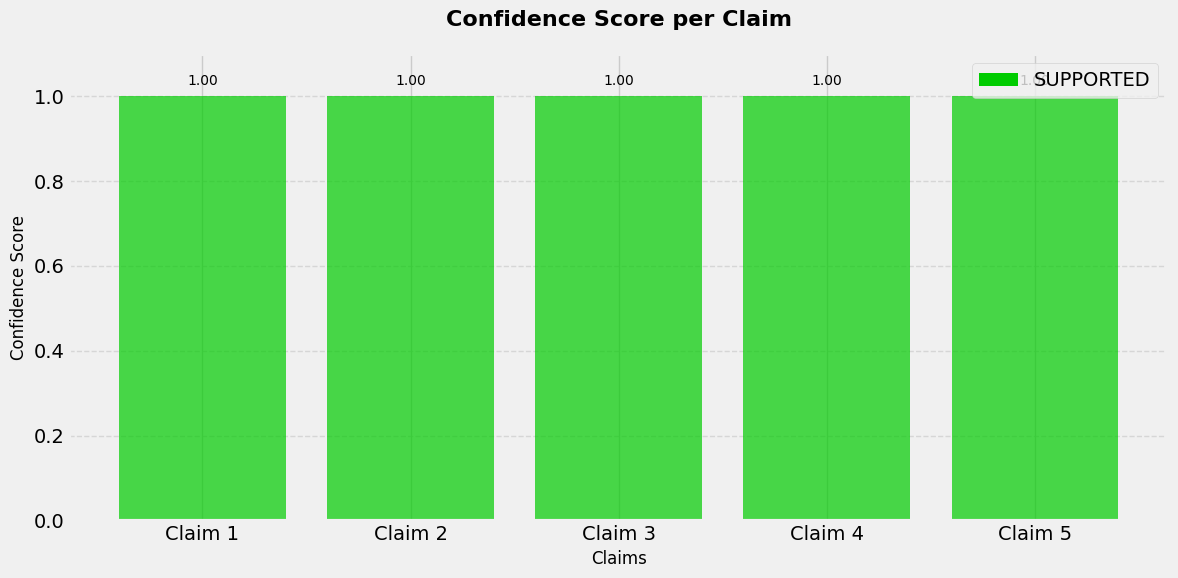

,Claim,Status,Confidence,Source Count,Contradictions
0,"Abraham Lincoln was born on February 12, 1809,...",SUPPORTED,1.0,2,No
1,He was largely self-educated and worked as a l...,SUPPORTED,1.0,2,No
2,His election as the 16th President of the Unit...,SUPPORTED,1.0,2,No
3,"In 1863, he issued the Emancipation Proclamati...",SUPPORTED,1.0,2,No
4,His leadership during the Civil War and his mo...,SUPPORTED,1.0,3,No


In [25]:
# Display results with visualizations
results_df = display_validation_results(trust_report, validation_results, extracted)
results_df

### 8. Detailed Analysis of a Specific Claim
Let's examine one of the claims in detail to better understand the validation process.


In [19]:
def analyze_claim_details(
    claim_id: str,
    validation_results: list[ValidationResult],
    extracted: ExtractedReport,
):
    """Display detailed analysis for a specific claim"""
    # Find the validation result
    result = next((r for r in validation_results if r.claim_id == claim_id), None)
    if not result:
        print(f"Claim {claim_id} not found in validation results")
        return

    # Find the original claim
    claim = next((c for c in extracted.claims if c.id == claim_id), None)
    if not claim:
        print(f"Claim {claim_id} not found in extracted claims")
        return

    # Print claim details
    console.print(
        Panel.fit(
            f"[bold]Original Statement:[/bold]\n{result.statement}\n\n"
            f"[bold]Verification Question:[/bold]\n{result.verification_question}\n\n"
            f"[bold]Sources:[/bold]\n"
            + "\n".join([f"- {url}" for url in claim.source_urls])
            + "\n\n"
            f"[bold]Status:[/bold] {result.status}\n"
            f"[bold]Confidence:[/bold] {result.confidence:.2f}\n"
            f"[bold]Has Contradictions:[/bold] {'Yes' if result.has_contradictions else 'No'}\n\n"
            f"[bold]Reasoning:[/bold]\n{result.reasoning}",
            title=f"Claim Analysis: {claim_id}",
            border_style="blue",
        )
    )


# %%
# Find an interesting claim to analyze (e.g., one with sources or contradictions)
if validation_results:
    # Find a claim that's not UNVERIFIABLE
    verified_claims = [r for r in validation_results if r.status != "UNVERIFIABLE"]
    if verified_claims:
        analyze_claim_details(
            verified_claims[0].claim_id, validation_results, extracted
        )
    else:
        analyze_claim_details(
            validation_results[0].claim_id, validation_results, extracted
        )

╭─────────────────────────────────────── Claim Analysis: claim-098920da-0 ────────────────────────────────────────╮
│ Original Statement:                                                                                             │
│ Abraham Lincoln was born on February 12, 1809, in a log cabin in Kentucky.                                      │
│                                                                                                                 │
│ Verification Question:                                                                                          │
│ Can it be verified that Abraham Lincoln was born on February 12, 1809, in a log cabin in Kentucky?              │
│                                                                                                                 │
│ Sources:                                                                                                        │
│ - https://en.wikipedia.org/wiki/Abraham_Lincoln                                                                 │
│ - https://millercenter.org/president/lincoln/life-in-brief                                                      │
│                                                                                                                 │
│ Status: SUPPORTED                                                                                               │
│ Confidence: 1.00                                                                                                │
│ Has Contradictions: No                                                                                          │
│                                                                                                                 │
│ Reasoning:                                                                                                      │
│ The claim is explicitly supported by the widely accepted historical details about Abraham Lincoln as presented  │
│ in the provided sources, notably his biography on Wikipedia and related historical texts. These sources         │
│ consistently state that he was born on February 12, 1809, in a log cabin in Kentucky. Therefore, the claim is   │
│ directly supported by the provided sources.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### 9. Conclusion

This has culminated into streamlined system for validating AI-generated research:
 
1. **Direct URL References**: Claims are linked directly to their source URLs, avoiding citation parsing complexity
2. **Single-Call Validation**: Each claim is validated against all its sources in a single LLM call
3. **Rich Visualizations**: Results are presented with clear, informative charts
4. **Contradiction Detection**: The system identifies when sources contradict each other or the claim
 
This Truth Layer provides a powerful foundation for assessing the trustworthiness of AI-generated research, addressing the critical gap between convenience and confidence.